## **Train a Bayesian Neural Network**

In [1]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
import pylab as plt
import scipy.stats
from matplotlib.patches import Ellipse

# Colab in order to download files
from google.colab import files


# Scikit-learn for scaling and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Tensorflow and Keras
import tensorflow as tf
import tensorflow_probability as tfp


from tensorflow import keras 
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# Import some layers etc that are useful in the Functional approach
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input


# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

In [2]:
# Mount drive to upload/download the datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load data**

In [3]:
# Images
X_train = np.float64(np.load("/content/drive/My Drive/BNN_final_codes/X_train.npy"))
X_val = np.float64(np.load("/content/drive/My Drive/BNN_final_codes/X_val.npy"))


# Labels
y_train = np.float64(np.load("/content/drive/My Drive/BNN_final_codes/y_train.npy"))
y_val = np.float64(np.load("/content/drive/My Drive/BNN_final_codes/y_val.npy"))

Scale 

In [4]:
scaler = StandardScaler()

# Rescale the labels
scaler.fit(y_train)
y_train_sc = scaler.transform(y_train)
y_val_sc = scaler.transform(y_val)

In [5]:
# Define basic numbers
IMAGE_SHAPE = [64, 64, 3]
NUM_TRAIN_EXAMPLES = 100000
NUM_VAL_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 20000
NUM_CLASSES = 5

**Define KL divergence function**

In [6]:
tfd = tfp.distributions

# KL divergence weighted by the number of training samples, using
# lambda function to pass as input to the kernel_divergence_fn on
# flipout layers.
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                           tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

**Build the deep learning model**

In [7]:
# Bayesian DeepShadows in functional form
model_input = Input(shape=(64,64,3))
# Convolutional part =================
# 1st convolutional chunk 
x = tfp.layers.Convolution2DFlipout(
          filters = 4, 
          kernel_size=(3,3),
          #activity_regularizer = regularizers.l2(0.005),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(model_input)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 2nd convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 8, 
          kernel_size=(3,3),
          #activity_regularizer = regularizers.l2(0.005),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 3rd convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 16, 
          kernel_size=(3,3),
          #activity_regularizer = regularizers.l2(0.005),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 4th convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 32, 
          kernel_size=(3,3),
          #activity_regularizer = regularizers.l2(0.005),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)


# 5th convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 64, 
          kernel_size=(3,3),
          #activity_regularizer = regularizers.l2(0.005),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)                    
# ====================================
x = keras.layers.Flatten()(x)
# ====================================
x = tfp.layers.DenseFlipout(
          units = 1024,
          #activity_regularizer = regularizers.l2(0.012),
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = tfp.layers.DenseFlipout(
          units = 512,
          #activity_regularizer = regularizers.l2(0.012),
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
distribution_params = keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(5))(x)
model_output = tfp.layers.MultivariateNormalTriL(event_size=5)(distribution_params)
model = Model(model_input, model_output)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


In [8]:
# Define loss
def negloglik(y_true, y_pred):
    y_pred = tfp.distributions.MultivariateNormalTriL(y_pred)
    return -tf.reduce_mean(y_pred.log_prob(y_true))


# Define the optimizer 
optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.2, rho=0.98)
model.compile(optimizer,
              loss=negloglik,
              metrics=['mae'],experimental_run_tf_function=False)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/BNN_final_codes/BNN_weights.h5',
    save_weights_only=True,
    monitor='val_mae',
    mode='max',
    save_best_only=False)

In [9]:
EPOCHS = 140

model.fit(x=X_train, y=y_train_sc,
          epochs=EPOCHS, batch_size=64,
          shuffle=True,
          validation_data=(X_val,y_val_sc))#,
          #callbacks=[model_checkpoint_callback])

Epoch 1/140
1563/1563 [==============================] - 47s 19ms/step - loss: 27.2531 - mae: 0.7625 - val_loss: 26.3681 - val_mae: 0.5701
Epoch 2/140
1563/1563 [==============================] - 20s 13ms/step - loss: 26.0035 - mae: 0.4732 - val_loss: 25.7701 - val_mae: 0.4075
Epoch 3/140
1563/1563 [==============================] - 21s 13ms/step - loss: 25.6135 - mae: 0.3602 - val_loss: 25.5083 - val_mae: 0.3280
Epoch 4/140
1563/1563 [==============================] - 20s 13ms/step - loss: 25.4468 - mae: 0.3079 - val_loss: 25.3970 - val_mae: 0.2926
Epoch 5/140
1563/1563 [==============================] - 20s 13ms/step - loss: 25.3517 - mae: 0.2780 - val_loss: 25.3142 - val_mae: 0.2673
Epoch 6/140
1563/1563 [==============================] - 20s 13ms/step - loss: 25.2827 - mae: 0.2577 - val_loss: 25.2599 - val_mae: 0.2514
Epoch 7/140
1563/1563 [==============================] - 21s 13ms/step - loss: 25.2300 - mae: 0.2432 - val_loss: 25.2052 - val_mae: 0.2371
Epoch 8/140
1563/1563 [====

**Save the model weights**

In [36]:
#model.save_weights('/content/drive/My Drive/BNN_final_codes/BNN_weights.h5',overwrite=True)

In [22]:
i = 150
X_0 = X_val[i]
y_0 = y_val[i]
print(y_0)

[122.93822164   0.3352523    1.36148976  27.071681    11.07643137]


In [23]:
pred_dist = model(X_0.reshape(1,64,64,3))

In [24]:
prediction_mean = pred_dist.mean().numpy()[0]
prediction_cov = pred_dist.covariance().numpy()[0]
print(prediction_mean)
print(prediction_cov)
preds = np.random.multivariate_normal(prediction_mean,prediction_cov,350)


[ 0.76978946 -0.07300649  0.9706775   1.2653716  -1.2597127 ]
[[ 8.0230286e-08  7.0330752e-06 -6.9464927e-06  8.8791494e-06
  -5.9618633e-06]
 [ 7.0330752e-06  6.1656337e-04 -6.0941494e-04  7.8059337e-04
  -5.2036071e-04]
 [-6.9464927e-06 -6.0941494e-04  6.0775451e-04 -7.9941703e-04
   4.8515745e-04]
 [ 8.8791494e-06  7.8059337e-04 -7.9941703e-04  1.2467391e-03
  -3.8357981e-04]
 [-5.9618633e-06 -5.2036071e-04  4.8515745e-04 -3.8357981e-04
   1.9301825e-03]]


In [25]:
n_rands = 800
for i in range(n_rands):
  pred_dist = model(X_0.reshape(1,64,64,3))
  prediction_mean = pred_dist.mean().numpy()[0]
  prediction_cov = pred_dist.covariance().numpy()[0]
  preds_loc = np.random.multivariate_normal(prediction_mean,prediction_cov,350)
  preds = np.concatenate((preds,preds_loc))

In [26]:
#! apt-get update
#! sudo apt-get install texlive-latex-recommended 
#! sudo apt install texlive-latex-extra
#! sudo apt install dvipng
#! apt install cm-super

In [27]:
y_0_new = scaler.inverse_transform(y_0.reshape(-1,5))

preds_new = scaler.inverse_transform(np.asarray(preds))

In [28]:
#!pip install chainconsumer
from chainconsumer import ChainConsumer

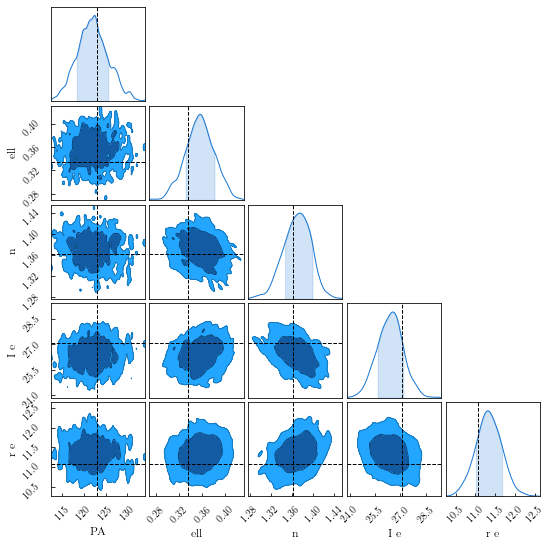

In [29]:
c = ChainConsumer()
c.add_chain(preds_new,parameters=["PA", "ell", "n", "I e", "r e"])
fig = c.plotter.plot(figsize=(8,8), truth=y_0)

In [31]:
#!pip3 install pyimfit
import pyimfit

In [48]:
model_im = pyimfit.SimpleModelDescription()
# define the X0,Y0 
model_im.x0.setValue(32.)
model_im.y0.setValue(32.)
# create a FlatSky uniform background
FlatSky_function = pyimfit.make_imfit_function("FlatSky")
FlatSky_function.I_sky.setValue(110.)
# create a Sersic profile
Sersic_function = pyimfit.make_imfit_function("Sersic")
Sersic_function.PA.setValue(50.)
Sersic_function.ell.setValue(0.2)
Sersic_function.n.setValue(1.0)
Sersic_function.I_e.setValue(10.)
Sersic_function.r_e.setValue(20)


model_im.addFunction(FlatSky_function)
model_im.addFunction(Sersic_function)

In [49]:
imfit_blah = pyimfit.Imfit(model_im)
imfit_blah.loadData(X_0[:,:,0])

In [34]:
nIterations = 700

imfit_blah.doFit()
parameterNames, bootstrapResults = imfit_blah.runBootstrap(nIterations, getColumnNames=True)

In [50]:
nIterations = 1000

imfit_blah.doFit()
parameterNames, bootstrapResults = imfit_blah.runBootstrap(nIterations, getColumnNames=True)

In [51]:
X_boot = np.copy(bootstrapResults)

Boot_chain = np.column_stack((X_boot[:,3],X_boot[:,4],X_boot[:,5],X_boot[:,6]*100,X_boot[:,7]))

/usr/local/lib/python3.7/dist-packages/chainconsumer/plotter.py:1029: UserWarning: Attempting to set identical left == right == -1525.40278013535 results in singular transformations; automatically expanding.
  ax.set_xlim(extents[p2])
/usr/local/lib/python3.7/dist-packages/chainconsumer/plotter.py:1026: UserWarning: Attempting to set identical bottom == top == 9.98429144185462 results in singular transformations; automatically expanding.
  ax.set_ylim(extents[p1])
/usr/local/lib/python3.7/dist-packages/chainconsumer/plotter.py:1029: UserWarning: Attempting to set identical left == right == 9.98429144185462 results in singular transformations; automatically expanding.
  ax.set_xlim(extents[p2])
/usr/local/lib/python3.7/dist-packages/chainconsumer/plotter.py:1026: UserWarning: Attempting to set identical bottom == top == -49.44253243735358 results in singular transformations; automatically expanding.
  ax.set_ylim(extents[p1])
/usr/local/lib/python3.7/dist-packages/chainconsumer/plotter.

IndexError: ignored

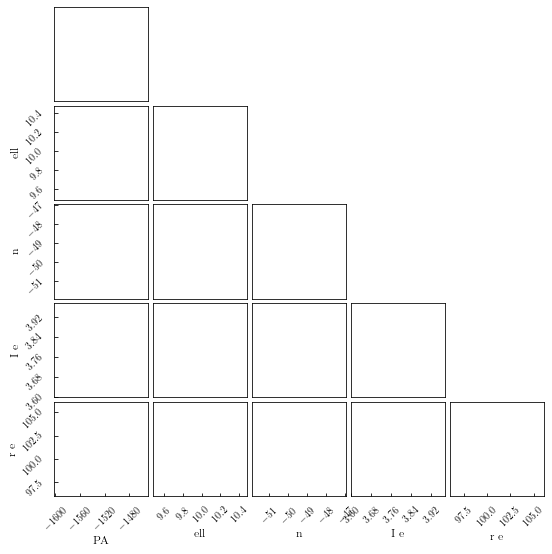

In [52]:
c = ChainConsumer()
c.add_chain(Boot_chain, parameters=['PA', 'ell', 'n', 'I e', 'r e'])
fig = c.plotter.plot(figsize=(8,8), truth=y_0_new[0])